# Laboratorium 4

# Narzędzie graficzne

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()
        
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

# Dane

In [2]:
# Od użytkownika
def collection_to_lines(collection):
    lines = []
    x_coordinates = set()
    for elem in collection:
        for line in elem.lines:
            if line[0][0] == line[1][0] or line[0][0] in x_coordinates or line[1][0] in x_coordinates:
                continue
            elif line[0][0] < line[1][0]:
                lines.append(((line[0][0],line[0][1]),(line[1][0],line[1][1])))
            else:
                lines.append(((line[1][0],line[1][1]),(line[0][0],line[0][1])))
            x_coordinates.add(line[0][0])
            x_coordinates.add(line[1][0])
    return lines

# Losowe
def random_lines(n,lowerLeft,upperRight):
    x_length = upperRight[0] - lowerLeft[0]
    y_length = upperRight[1] - lowerLeft[1]
    lines = []
    x_coordinates = set()
    while n > 0:
        start=(np.random.uniform(lowerLeft[0],upperRight[0]),np.random.uniform(lowerLeft[1],upperRight[1]) )
        end=(np.random.uniform(start[0],upperRight[0]),np.random.uniform(lowerLeft[1],upperRight[1]))
        if start is end or start[0] in x_coordinates or end[0] in x_coordinates:
            continue
        lines.append((start,end))
        x_coordinates.add(start[0])
        x_coordinates.add(end[0])
        n -= 1
    return lines

In [3]:
# wyznacznik
def det3x3(p,q,r):
    return p[0]*q[1] + q[0]*r[1] + r[0]*p[1] - r[0]*q[1] - p[0]*r[1] - q[0]*p[1]

from enum import Enum
class Vertex(Enum):
    START = 0
    END = 1
    INTERSECTING = 2

def orientation(p,q,r,e = 10**(-13)):
    d = det3x3(p,q,r)
    if d > e:
        return 1
    elif d < e:
        return -1
    else:
        return 0
    
def check_intersection(line, line2, e = 10**(-13)):
    o1 = orientation(line2[0],line2[1],line[0],e)
    o2 = orientation(line2[0],line2[1],line[1],e)
    o3 = orientation(line[0],line[1],line2[0],e)
    o4 = orientation(line[0],line[1],line2[1],e)
    
    if o1 is not o2 and o3 is not o4:
        return True
    return False

class Line:
    def set_instance():
        pass
    def __init__(self,line):
        self.line = line
        self.start = line[0]
        self.end = line[1]
        self.slope = (self.end[1] - self.start[1]) / (self.end[0] - self.start[0])
        self.y_interception = self.start[1] - self.slope * self.start[0]
    def change_ordering(x):
        Line.ordering = x # x-coordinate of the event to correct insert line if intersect event is encountered
    
    def __hash__(self):
        return hash(self.line)
    def __eq__(self, other):
        return self.start == other.start and self.end == other.end
    def __gt__(self, other):
        return self.slope*Line.ordering+self.y_interception > other.slope*Line.ordering+other.y_interception
    
def add_intersection_if_any(Q,line,line2,e=10**(-13)): # line,line2 are Line objects
    if check_intersection(line.line,line2.line,e):
        x = ((line2.y_interception - line.y_interception)/(line.slope - line2.slope))
        Q.add((x,line.line,line2.line,Vertex.INTERSECTING))

def get_point(x,line): # line is a tuple of 2 vertices not Line object
    slope = (line[1][1] - line[0][1]) / (line[1][0] - line[0][0])
    y_interception = line[0][1] - slope * line[0][0] 
    return (x,slope*x + y_interception)

# Algorytm sprawdzający czy choć jedna para odcinków się przecina

In [4]:
import queue
from sortedcontainers import SortedSet
def is_intersection(lines):
    
    Q = queue.PriorityQueue() # zdarzenia - default first elem in tuple sort (x - coordinate)
    SL = SortedSet(key = lambda line: line[0][1]) # stan miotły - start vertex y-coordinate sort
    
    for line in lines:
        Q.put((line[0][0],line,Vertex.START))
        Q.put((line[1][0],line,Vertex.END))
  
    while not Q.empty():        
        x, line, vertex_type  = Q.get()
        if vertex_type is Vertex.START:
            SL.add(line)
            i = SL.index(line)
            if i-1 >= 0 and check_intersection(SL[i-1], line):
                return True
            if i+1 < len(SL) and check_intersection(SL[i+1], line):
                return True
        elif vertex_type is Vertex.END:
            i = SL.index(line) 
            if i+1 < len(SL) and i-1 >= 0 and check_intersection(SL[i+1],SL[i-1]):
                return True
            SL.remove(line)
    return False

# Wizualizacja algorytmu 1

In [5]:
def plot_is_intersection(lines):
    Q = queue.PriorityQueue()
    SL = SortedSet(key = lambda line: line[0][1])
    lines_out = lines.copy()
    lines_in = []
    plot = Plot(scenes = [Scene(points = [PointsCollection([])],lines = [LinesCollection(lines_out.copy(),color="blue")])])
    for line in lines:
        Q.put((line[0][0],line,Vertex.START))
        Q.put((line[1][0],line,Vertex.END))
    
    y_max = float("-inf")
    y_min = float("inf")
    for line in lines:
        for point in line:
            y_max = max(y_max,point[1])
            y_min = min(y_min,point[1])
            
    while not Q.empty():        
        x , line, vertex_type  = Q.get()
        sweep_line = [[(x,y_max),(x,y_min)]]
        lines_in.append(line)
        
        plot.add_scene(Scene(points = [PointsCollection([])],lines = [LinesCollection(lines_out.copy(),color="blue"),
                                            LinesCollection(lines_in.copy(),color="darkblue"),
                                            LinesCollection(sweep_line.copy(),color="red")]))
        if vertex_type is Vertex.START:
            SL.add(line)
            i = SL.index(line)
            if i-1 >= 0 and check_intersection(SL[i-1], line):
                return plot
            if i+1 < len(SL) and check_intersection(SL[i+1], line):
                return plot
        elif vertex_type is Vertex.END:
            i = SL.index(line) 
            if i+1 < len(SL) and i-1 >= 0 and check_intersection(SL[i+1],SL[i-1]):
                return plot
            SL.remove(line)
            lines_out.append(line)
            lines_in.remove(line)

    return plot

# Algorytm wykrywający wszystkie przecięcia

In [6]:
def intersections(lines,e=10**(-13)):
    
    Q = SortedSet(key = lambda tuple : tuple[0]) # x default sorting
    SL = SortedSet()
    stack = set() # all intersections points to skip intersections points added multiple times to Q 
    intersections_array = [] # result array
    Line.set_instance() # instance of Line class to be up to date with sweep line x position when inserting new line
    
    for line in lines:
        Q.add((line[0][0],line,None,Vertex.START))
        Q.add((line[1][0],line,None,Vertex.END))
    
    while len(Q) > 0:
        x , line, line2, vertex_type = Q.pop(0)
        if x in stack:
                continue
        if vertex_type is Vertex.START:
            Line.change_ordering(x)
            SL.add(Line(line))
            i = SL.index(Line(line))
            if i-1 >= 0:
                add_intersection_if_any(Q,SL[i-1],Line(line),e)
            if i+1 < len(SL):
                add_intersection_if_any(Q,Line(line),SL[i+1],e)
        elif vertex_type is Vertex.END:
            i = SL.index(Line(line))
            if i-1 >= 0 and i+1 < len(SL):
                add_intersection_if_any(Q,SL[i-1],SL[i+1],e)
            SL.remove(Line(line))
        else:
            
            stack.add(x)
            intersections_array.append([get_point(x,line), line, line2])
            SL.remove(Line(line)) # line is below intersection on the left of the sweep line
            SL.remove(Line(line2)) # line2 is above intersection on the left of the sweep line
            Line.change_ordering(x+e)
            SL.add(Line(line))
            SL.add(Line(line2))
            
            i = SL.index(Line(line)) # line is above intersection on the right of the sweep line
            j = SL.index(Line(line2)) # line2 is below intersection on the right of the sweep line 
            
            if i + 1 < len(SL):
                add_intersection_if_any(Q,SL[i],SL[i+1],e)
            if j - 1 >= 0:
                add_intersection_if_any(Q,SL[j-1],SL[j],e)
                
    return intersections_array # result array

def print_intersections(lines):
    arr = intersections(lines)
    print("Liczba przecięć = ",len(arr))
    for i in range(len(arr)):
        print("Przecięcie nr ",i," point = ",arr[i][0]," \n Linie : ",arr[i][1]," , ",arr[i][2])

# Algorytm 2 wizualizacja 

In [7]:
def plot_add_intersection_if_any(intersections_points,Q,line,line2,e=10**(-13)): # line,line2 are Line objects
    if check_intersection(line.line,line2.line,e):
        x = ((line2.y_interception - line.y_interception)/(line.slope - line2.slope))
        intersections_points.append(get_point(x,line.line))
        Q.add((x,line.line,line2.line,Vertex.INTERSECTING))
        
def plot_intersections(lines,e=10**(-13)):
    lines_out = lines.copy()
    lines_in = []
    plot = Plot(scenes = [Scene(points = [PointsCollection([])],lines = [LinesCollection(lines_out.copy(),color="blue")])])
    Q = SortedSet(key = lambda tuple : tuple[0]) # x default sorting
    SL = SortedSet()
    stack = set() # all intersections points to skip intersections points added multiple times to Q
    intersections_points = []
    intersections_array = [] # result array
    Line.set_instance() # instance of Line class to be up to date with sweep line x position when inserting new line
    
    for line in lines:
        Q.add((line[0][0],line,None,Vertex.START))
        Q.add((line[1][0],line,None,Vertex.END))
    
    y_max = float("-inf")
    y_min = float("inf")
    for line in lines:
        for point in line:
            y_max = max(y_max,point[1])
            y_min = min(y_min,point[1])
    
    while len(Q) > 0:
        x , line, line2, vertex_type = Q.pop(0)
        if x in stack:
                continue
        sweep_line = [[(x,y_max),(x,y_min)]]
        
        
        plot.add_scene(Scene(lines = [LinesCollection(lines_out.copy(),color="blue"),
                                            LinesCollection(lines_in.copy(),color="darkblue"),
                                            LinesCollection(sweep_line.copy(),color="red")],
                             points = [PointsCollection(intersections_points.copy(),color="red")]))
        
        if vertex_type is Vertex.START:
            Line.change_ordering(x)
            SL.add(Line(line))
            lines_in.append(line)
            i = SL.index(Line(line))
            if i-1 >= 0:
                plot_add_intersection_if_any(intersections_points,Q,SL[i-1],Line(line),e)
            if i+1 < len(SL):
                plot_add_intersection_if_any(intersections_points,Q,Line(line),SL[i+1],e)
        elif vertex_type is Vertex.END:
            i = SL.index(Line(line))
            if i-1 >= 0 and i+1 < len(SL):
                plot_add_intersection_if_any(intersections_points,Q,SL[i-1],SL[i+1],e)
            SL.remove(Line(line))

            lines_in.remove(line)
        else:
            
            stack.add(x)
            intersections_array.append([get_point(x,line), line, line2])
            SL.remove(Line(line)) # line is below intersection on the left of the sweep line
            SL.remove(Line(line2)) # line2 is above intersection on the left of the sweep line
            Line.change_ordering(x+e)
            SL.add(Line(line))
            SL.add(Line(line2))
            
            if not line in lines_in:
                lines_in.append(line)
            if not line2 in lines_in:
                lines_in.append(line2)
            
            i = SL.index(Line(line)) # line is above intersection on the right of the sweep line
            j = SL.index(Line(line2)) # line2 is below intersection on the right of the sweep line 
            
            if i + 1 < len(SL):
                plot_add_intersection_if_any(intersections_points,Q,SL[i],SL[i+1],e)
            if j - 1 >= 0:
                plot_add_intersection_if_any(intersections_points,Q,SL[j-1],SL[j],e)
                
        
    return plot

# Narysuj linie

<IPython.core.display.Javascript object>


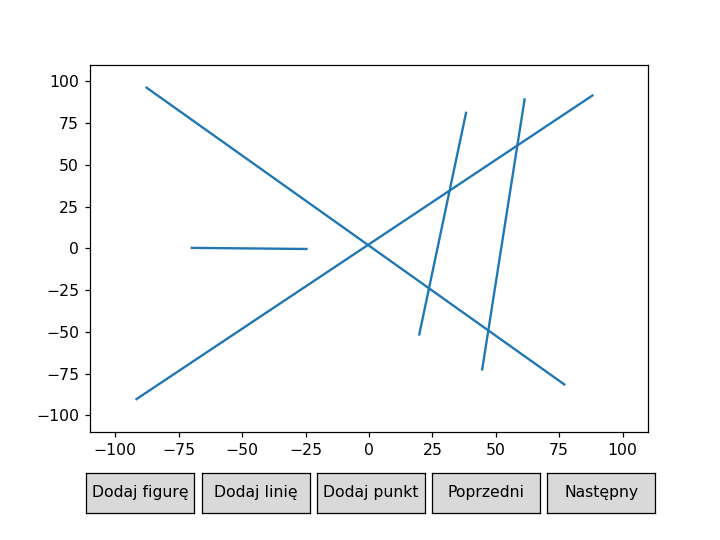

In [10]:
%matplotlib notebook
plot = Plot(scenes = [Scene(points = [PointsCollection([(-100,-100),(100,100)],color="white")])])
plot.draw()

# Algorytm 1

Czy choć jedna para prostych się przecina :  True


<IPython.core.display.Javascript object>


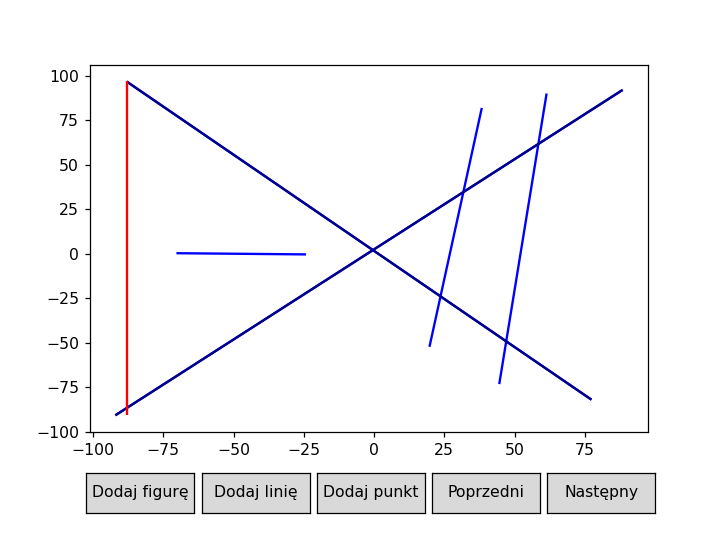

In [11]:
%matplotlib notebook
arr = collection_to_lines(plot.get_added_lines())
print("Czy choć jedna para prostych się przecina : ",is_intersection(arr))
plot_arr = plot_is_intersection(arr)
plot_arr.draw()


# Algorytm 2

<IPython.core.display.Javascript object>


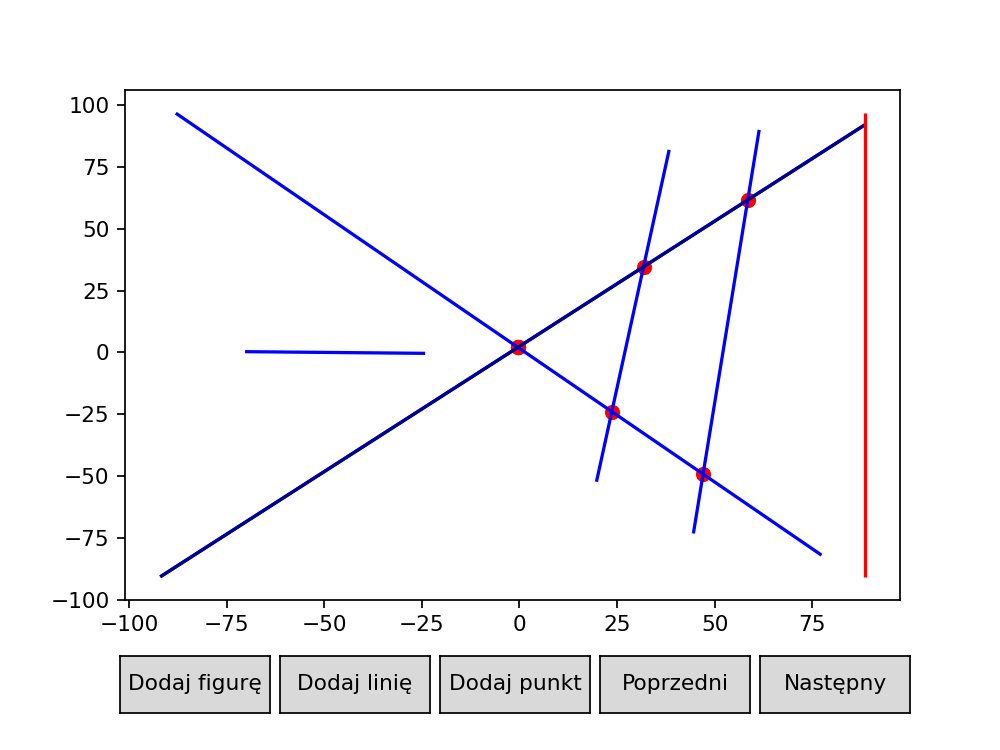

Liczba przecięć =  5
Przecięcie nr  0  point =  (-0.4016166453260914, 2.068420844737285)  
 Linie :  ((-92.05476699336884, -90.66874204897415), (88.46942655501826, 91.99057167651608))  ,  ((-88.06283150949787, 96.70870893141807), (77.3807168775989, -81.90648714701337))
Przecięcie nr  1  point =  (23.656191950603482, -23.90472976446756)  
 Linie :  ((19.71942655501826, -52.24962440191531), (38.34845881308277, 81.88027755886901))  ,  ((-88.06283150949787, 96.70870893141807), (77.3807168775989, -81.90648714701337))
Przecięcie nr  2  point =  (31.787044483404625, 34.637788063322176)  
 Linie :  ((19.71942655501826, -52.24962440191531), (38.34845881308277, 81.88027755886901))  ,  ((-92.05476699336884, -90.66874204897415), (88.46942655501826, 91.99057167651608))
Przecięcie nr  3  point =  (47.03774748057934, -49.1477879938152)  
 Linie :  ((44.55813623243762, -73.14423224505258), (61.41297494211503, 89.96851285298669))  ,  ((-88.06283150949787, 96.70870893141807), (77.3807168775989, -81.9064

In [26]:
%matplotlib notebook
plot2_arr = plot_intersections(arr)
plot2_arr.draw()
print_intersections(arr)

# Narysuj linie #2

<IPython.core.display.Javascript object>


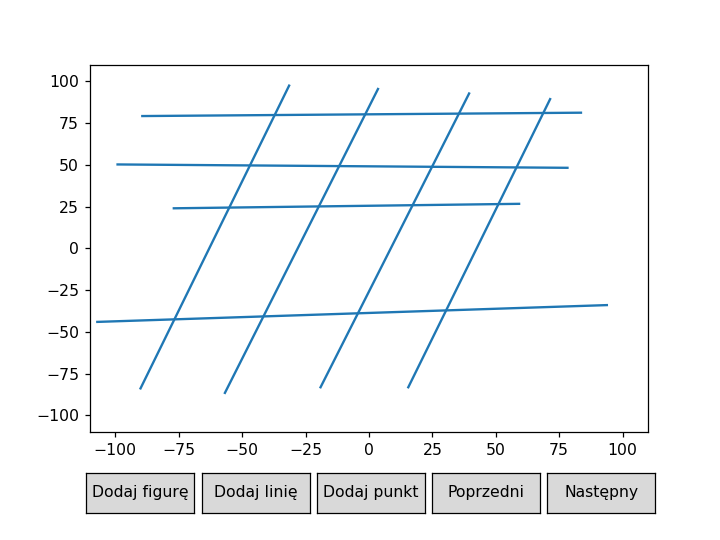

In [13]:
%matplotlib notebook
plot2 = Plot(scenes = [Scene(points = [PointsCollection([(-100,-100),(100,100)],color="white")])])
plot2.draw()

# Algorytm 1

Czy choć jedna para prostych się przecina :  True


<IPython.core.display.Javascript object>


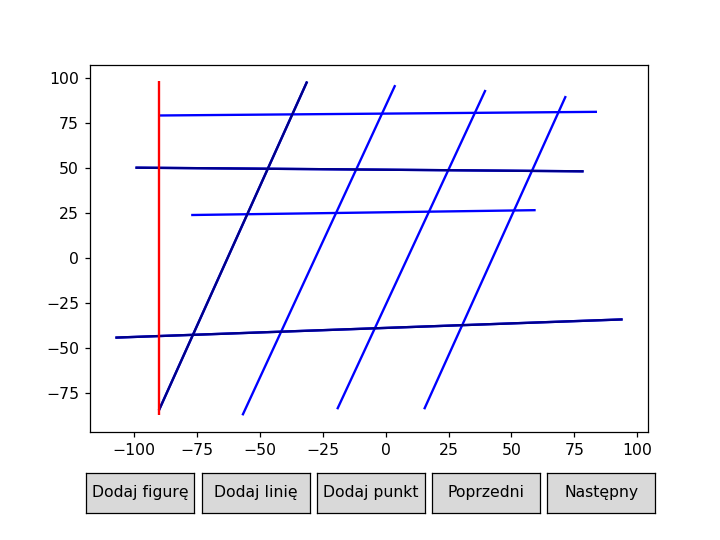

In [14]:
%matplotlib notebook
arr2 = collection_to_lines(plot2.get_added_lines())
print("Czy choć jedna para prostych się przecina : ",is_intersection(arr))
plot_arr2 = plot_is_intersection(arr2)
plot_arr2.draw()

# Algorytm 2

<IPython.core.display.Javascript object>


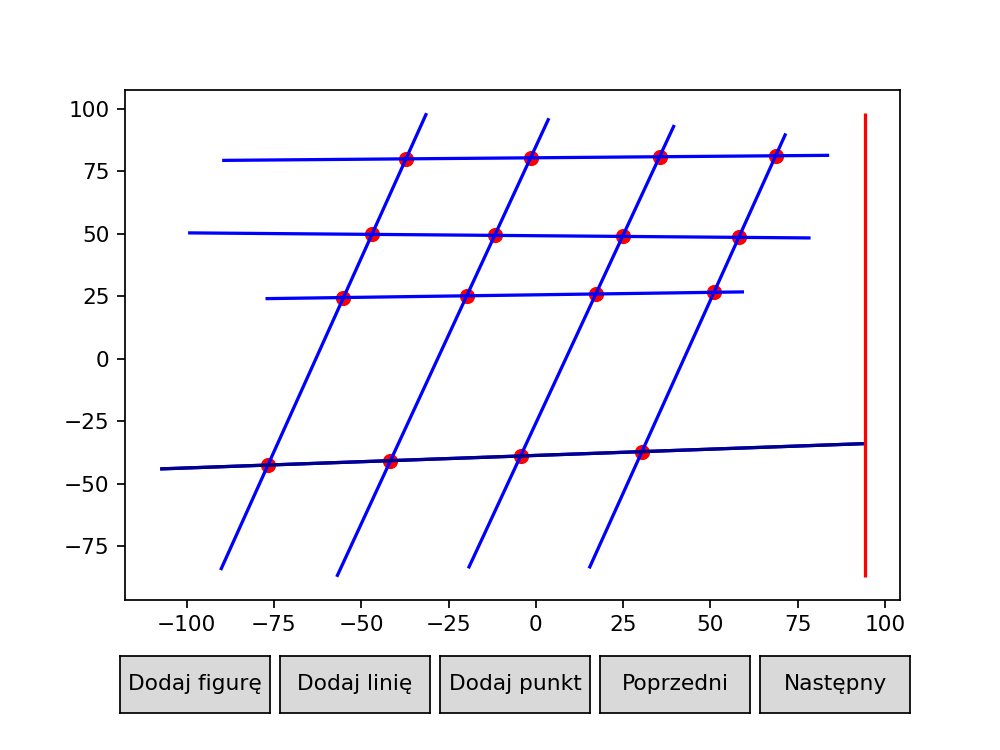

Liczba przecięć =  16
Przecięcie nr  0  point =  (-76.72035482353469, -42.512485782427774)  
 Linie :  ((-90.28057344498174, -84.49958464678598), (-31.28863796111078, 98.15972907870429))  ,  ((-107.57896054175595, -44.05840817619773), (94.23555558727631, -33.94811405855066))
Przecięcie nr  1  point =  (-55.091866558890814, 24.4567497738428)  
 Linie :  ((-90.28057344498174, -84.49958464678598), (-31.28863796111078, 98.15972907870429))  ,  ((-77.41767021917529, 24.01757221595915), (59.638781393727925, 26.71365064733169))
Przecięcie nr  2  point =  (-46.93695009264601, 49.70717481914821)  
 Linie :  ((-90.28057344498174, -84.49958464678598), (-31.28863796111078, 98.15972907870429))  ,  ((-99.595089574014, 50.304336921841525), (78.71136203888923, 48.282278098312105))
Przecięcie nr  3  point =  (-41.62132368584708, -40.75413095814153)  
 Linie :  ((-57.01444441272368, -87.19566307815853), (3.7516846195343874, 96.13767025517484))  ,  ((-107.57896054175595, -44.05840817619773), (94.235555587

In [28]:
%matplotlib notebook
plot2_arr2 = plot_intersections(arr2)
plot2_arr2.draw()
print_intersections(arr2)

# Losowe 

# Algorytm 1

Czy choć jedna para prostych się przecina :  True


<IPython.core.display.Javascript object>


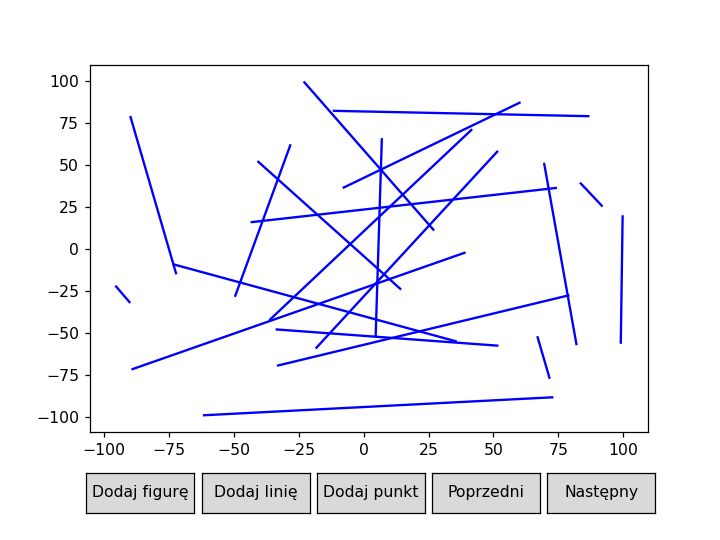

In [23]:
%matplotlib notebook
arr3 = random_lines(20,[-100,-100],[100,100])
print("Czy choć jedna para prostych się przecina : ",is_intersection(arr3))
plot_arr3 = plot_is_intersection(arr3)
plot_arr3.draw()

# Algorytm 2

<IPython.core.display.Javascript object>


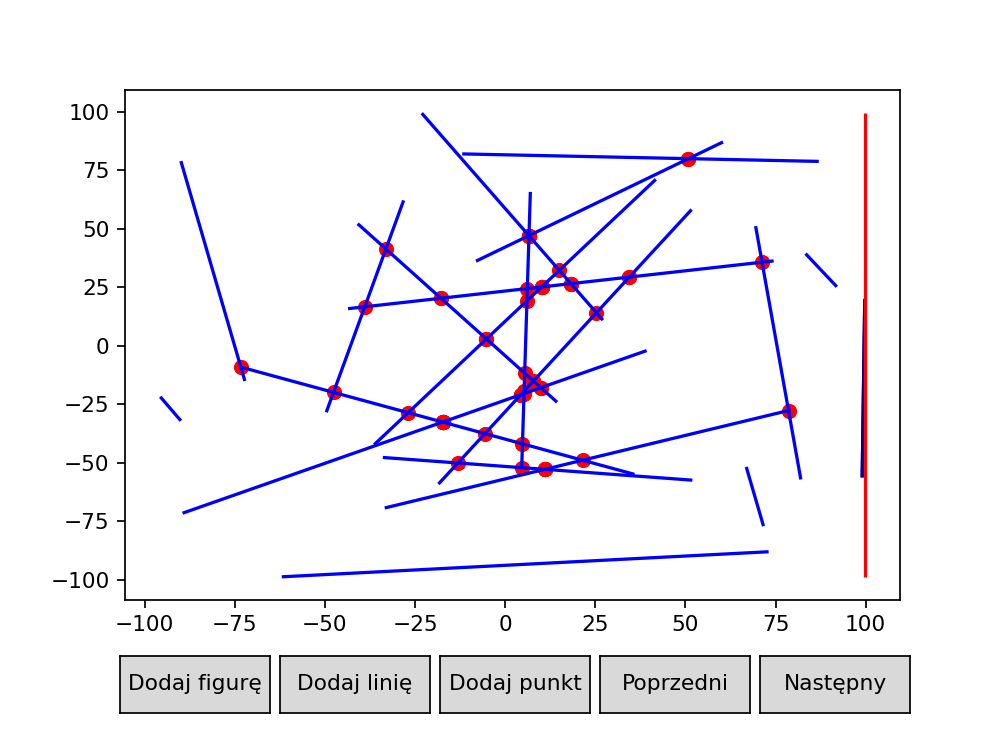

Liczba przecięć =  33
Przecięcie nr  0  point =  (-73.34682669461873, -9.102295119931998)  
 Linie :  ((-73.68834752773661, -8.958984123079759), (35.86116469353601, -54.928799954747355))  ,  ((-89.98657552013213, 78.9547062450857), (-72.22651344723565, -15.030955834016709))
Przecięcie nr  1  point =  (-47.63542980622283, -19.891463923779554)  
 Linie :  ((-49.652967958321966, -28.398482278014825), (-28.17953703371447, 62.144970798189206))  ,  ((-73.68834752773661, -8.958984123079759), (35.86116469353601, -54.928799954747355))
Przecięcie nr  2  point =  (-38.9625693021665, 16.67794786898645)  
 Linie :  ((-49.652967958321966, -28.398482278014825), (-28.17953703371447, 62.144970798189206))  ,  ((-43.601265435302786, 15.875835108587637), (74.48352403364402, 36.2947877029265))
Przecięcie nr  3  point =  (-33.10287191967578, 41.38556151745618)  
 Linie :  ((-49.652967958321966, -28.398482278014825), (-28.17953703371447, 62.144970798189206))  ,  ((-40.9337515412, 52.18006585096876), (14.4018

In [29]:
%matplotlib notebook
plot3_arr3 = plot_intersections(arr3)
plot3_arr3.draw()
print_intersections(arr3)